In [70]:
import pandas as pd
import numpy as np 
import os
import cv2 as cv
import matplotlib.pyplot as plt


In [71]:
df = pd.read_csv("train_1.csv",sep= ',')

<AxesSubplot: >

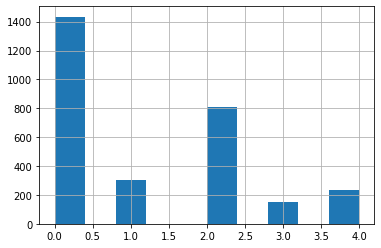

In [72]:
df["diagnosis"].hist()

In [73]:
df["diagnosis"].value_counts()

0    1434
2     808
1     300
4     234
3     154
Name: diagnosis, dtype: int64

In [74]:
files = os.listdir('train_images/train_images/')

In [75]:
len(files)

2930

In [76]:
# resimleri görselleştirme 

img_list = []

for i in files[0:20]:
    img = cv.imread('train_images/train_images/' + i)
    img = cv.resize(img , (400,400))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_list.append(img)



In [77]:
len(img_list)

20

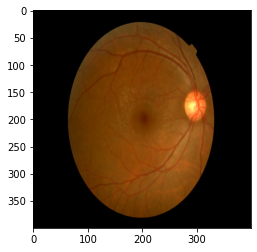

In [78]:
plt.imshow(img_list[3])

In [79]:
# görüntü ön işleme 


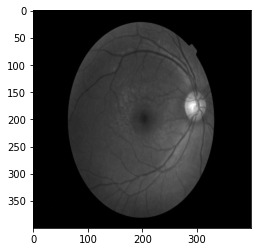

In [80]:
copy= img_list[3].copy()
copy = cv.cvtColor(copy, cv.COLOR_BGR2GRAY)
plt.imshow(copy, cmap='gray')

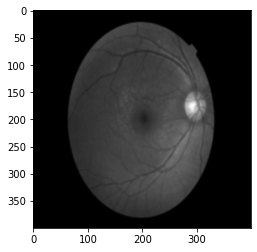

In [81]:
# gaussian blur

blur = cv.GaussianBlur(copy, (5,5), 0)
# çekirdek boyutubnu ne kadar büyük girersen o kadar blurlanır.

plt.imshow(blur, cmap='gray')

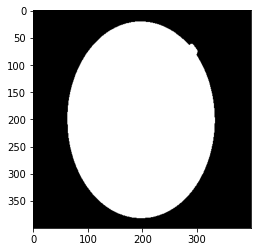

In [82]:
# threhold uygulama
thresh = cv.threshold(blur, 10, 255, cv.THRESH_BINARY)[1]
plt.imshow(thresh, cmap='gray')

In [83]:
# kontur bulma işlemleri 
contours = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)


In [84]:


contours[0][0].shape

(908, 1, 2)

In [85]:
contours  = contours[0][0][:,0,:]

In [86]:
contours.shape

(908, 2)

In [87]:
# x değeğerleri için uç noktaları bulma 
contours[:, 0].argmax()

658

In [88]:
contours[:, 0].argmin()

200

In [89]:
# uç noktaların koordinatlarını belirleme
left = tuple(contours[contours[:, 0].argmin()])
rigth = tuple(contours[contours[:, 0].argmax()])
top = tuple(contours[contours[:, 1].argmin()])
bottom = tuple(contours[contours[:, 1].argmax()])

x1 = left[0]
y1 = top[1]
x2 = rigth[0]
y2 = bottom[1]


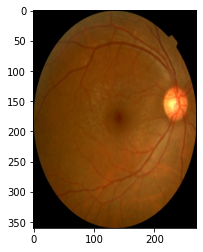

In [90]:
#crop image

crop_img = img_list[3][y1:y2 , x1:x2]

plt.imshow(crop_img, cmap='gray')

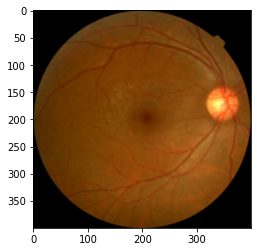

In [91]:
# model için 400x400 rezise edmeliyiz
resize_img  = cv.resize(crop_img, (400,400))
plt.imshow(resize_img, 'gray')

In [92]:
# adaptif histaoggram eşitmele - CLAHE
'''
lab renk haritasi :
 L = parlaklik ( siyah - beyaz )
 A = Yeşil - Kirmizi 
 B = Mavi - Sari 
 Renk katmanlarini içerir.

'''

lab_img = cv.cvtColor(resize_img, cv.COLOR_RGB2LAB)

lab_img.shape


(400, 400, 3)

In [93]:
l,a,b = cv.split(lab_img)

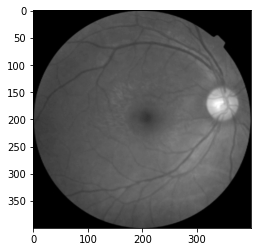

In [94]:
plt.imshow(l, 'gray')

In [95]:
#histogram eşitleme

flatten  = l.flatten()
flatten.shape

(160000,)

(array([34437.,   342.,   251.,   257.,   304.,  2398., 13238., 25385.,
        34672., 22212., 14748.,  6333.,  2402.,   655.,   309.,   500.,
          394.,   344.,   234.,   177.,   134.,    92.,    63.,    58.,
           61.]),
 array([  0. ,  10.2,  20.4,  30.6,  40.8,  51. ,  61.2,  71.4,  81.6,
         91.8, 102. , 112.2, 122.4, 132.6, 142.8, 153. , 163.2, 173.4,
        183.6, 193.8, 204. , 214.2, 224.4, 234.6, 244.8, 255. ]),
 <BarContainer object of 25 artists>)

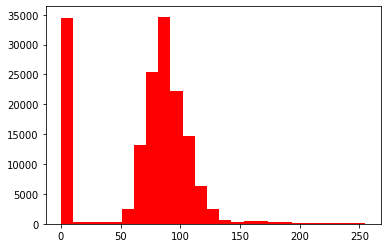

In [96]:
plt.hist(flatten, 25, [0,255], color = 'r')

In [97]:
# clahe = cv.createCLAHE(kontrast limiti, çevre boyutu)
# clahe.apply(img)
clahe = cv.createCLAHE(clipLimit= 7.0, tileGridSize=((8,8))) # eğer bulduğu pikselin değeri 7 nin üzerinde cıkarsa bulunduğu komşu değeri aktarır, dağıtır.
cl = clahe.apply(l)

(array([31376.,  3197.,  1023.,  1402.,  2200.,  3223.,  3887.,  5167.,
         7686., 12150., 17499., 17178., 14597., 11668.,  8829.,  6808.,
         4015.,  2741.,  1660.,  1344.,  1071.,   598.,   375.,   173.,
          133.]),
 array([  0. ,  10.2,  20.4,  30.6,  40.8,  51. ,  61.2,  71.4,  81.6,
         91.8, 102. , 112.2, 122.4, 132.6, 142.8, 153. , 163.2, 173.4,
        183.6, 193.8, 204. , 214.2, 224.4, 234.6, 244.8, 255. ]),
 <BarContainer object of 25 artists>)

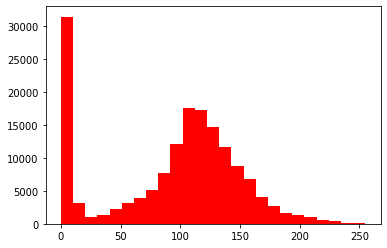

In [98]:
plt.hist(cl.flatten(), 25, [0,255], color = 'r')

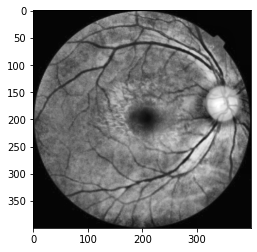

In [99]:
plt.imshow(cl, 'gray')

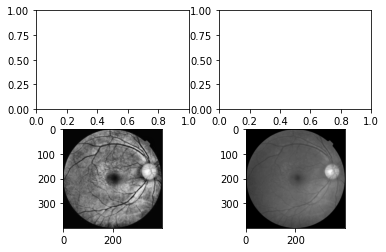

In [100]:
f, arr = plt.subplots(2,2)
arr[1,0].imshow(cl, 'gray')
arr[1,1].imshow(l, 'gray')

In [101]:
limg = cv.merge((cl, a, b))

In [102]:
result = cv.cvtColor(limg, cv.COLOR_LAB2RGB)

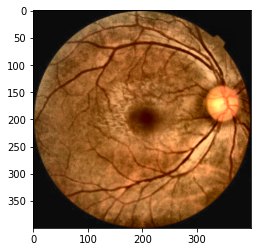

In [103]:
plt.imshow(result) 

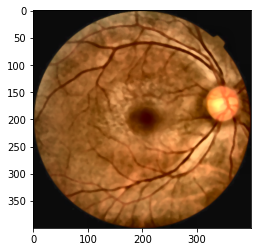

In [104]:
# kumlanma meydana geldi,
# median blur uygulanır

median_blur = cv.medianBlur(result, 5)
plt.imshow(median_blur)

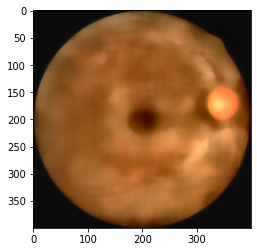

In [105]:
backgraund = cv.medianBlur(result, 25)
plt.imshow(backgraund)

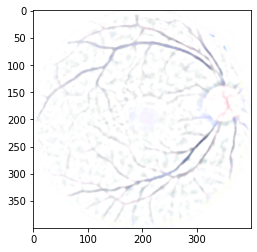

In [106]:
mask  = cv.addWeighted(median_blur, 1, backgraund, -1, 255)
plt.imshow(mask)

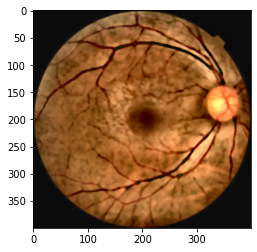

In [107]:
added_img = cv.bitwise_and(median_blur, mask)
plt.imshow(added_img)

In [108]:
# BÜTÜN ÖN İŞLEME KODLARININ TOPARLANMASI
img_list = []

from tqdm import tqdm_notebook as tqdm

for i in tqdm(files):
    img = cv.imread('train_images/train_images/' + i)
    img = cv.resize(img , (400,400))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    copy_img = img.copy()
    copy_img = cv.cvtColor(copy_img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(copy_img, (5,5), 0)
    thresh = cv.threshold(blur, 10, 255, cv.THRESH_BINARY)[1]
    contours = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours  = contours[0][0][:,0,:]
    left = tuple(contours[contours[:, 0].argmin()])
    rigth = tuple(contours[contours[:, 0].argmax()])
    top = tuple(contours[contours[:, 1].argmin()])
    bottom = tuple(contours[contours[:, 1].argmax()])
    x1 = left[0]
    y1 = top[1]
    x2 = rigth[0]
    y2 = bottom[1]
    copy2_img = img.copy()
    if x2-x1>100 and y2-y1>100:
        copy2_img = copy2_img[y1:y2 , x1:x2]
        copy2_img  = cv.resize(copy2_img, (400,400))
    lab = cv.cvtColor(copy2_img, cv.COLOR_RGB2LAB)
    l,a,b = cv.split(lab)
    clahe = cv.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv.merge((cl,a,b))
    result = cv.cvtColor(limg, cv.COLOR_LAB2RGB)
    median_blur = cv.medianBlur(result, 3)
    backgraund = cv.medianBlur(result, 37)
    mask  = cv.addWeighted(median_blur, 1, backgraund, -1, 255)
    added_img = cv.bitwise_and(median_blur, mask)
    img_list.append(added_img)
    


C:\Users\hasan\AppData\Local\Temp\ipykernel_13240\79112354.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(files):


  0%|          | 0/2930 [00:00<?, ?it/s]

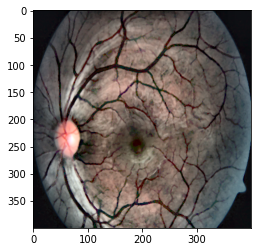

In [109]:
plt.imshow(img_list[100])

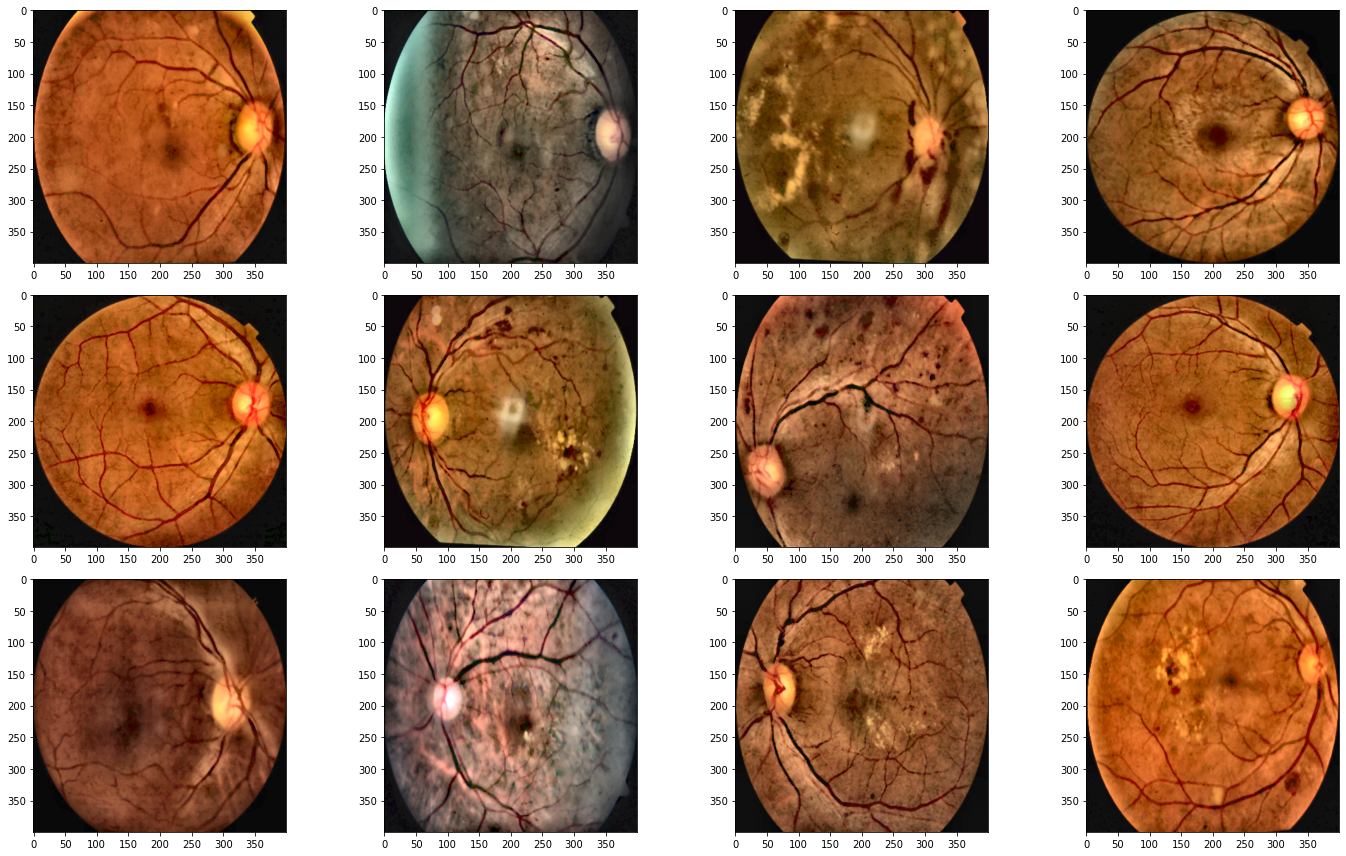

In [110]:
flg = plt.figure(figsize=(20,12))

for i in range(12):
    img = img_list[i]
    flg.add_subplot(3,4,i+1)
    plt.imshow(img)

plt.tight_layout()

In [111]:
# one hot encoding
df['diagnosis']

0       2
1       1
2       4
3       0
4       0
       ..
2925    0
2926    0
2927    0
2928    0
2929    0
Name: diagnosis, Length: 2930, dtype: int64

In [112]:
# pd.get_dummies(siniflandirma verisi) : kategorik değişkeni, 0 ve 1 lerden oluşan değerlere dönüştürür.(onehot encoding)

y_train = pd.get_dummies(df['diagnosis']).values

In [113]:
y_train

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=uint8)

In [114]:
df['diagnosis'][2]

4

In [115]:
y_train[2]

array([0, 0, 0, 0, 1], dtype=uint8)

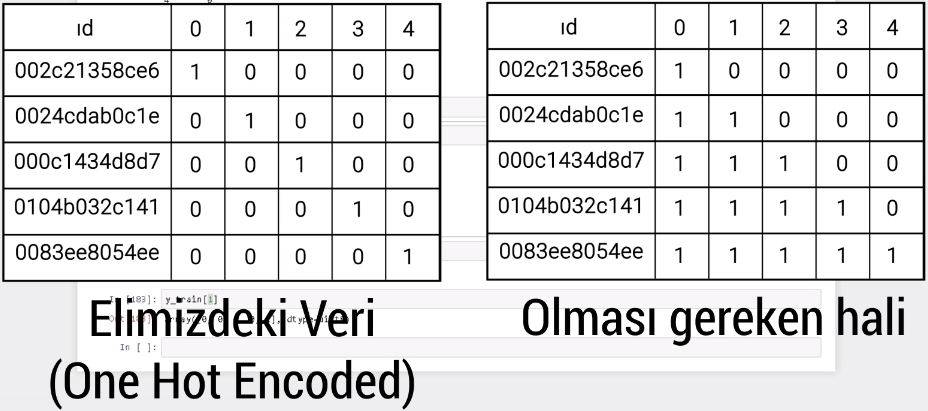

In [116]:
np.logical_and(0,0)
'''id 4 olan bir fotorafin aslında diğer bulgularında bulunduğunu biinmmektedir ondan dolayı modeli daha iyi eğitmek için sağ tarafdaki tablo gibi çevirlmesi gerekmetedir.'''

'id 4 olan bir fotorafin aslında diğer bulgularında bulunduğunu biinmmektedir ondan dolayı modeli daha iyi eğitmek için sağ tarafdaki tablo gibi çevirlmesi gerekmetedir.'

In [117]:
y_train_son = np.ones(y_train.shape, dtype='uint8')
y_train_son[:,4] = y_train[:,4]

In [118]:
for i in range(3, -1, -1):
    y_train_son[:,i] = np.logical_or(y_train[:,i], y_train_son[:,i+1]) # bu kısmı tekrar et! ve acıkla.

In [119]:
x_train = np.array(img_list)

In [120]:
x_train.shape

(2930, 400, 400, 3)

In [121]:
y_train_son.shape

(2930, 5)

In [122]:
# train ve test ayırma
from sklearn.model_selection import train_test_split

x_train, x_val , y_train, y_val = train_test_split(x_train,
                                                   y_train_son,
                                                   test_size=0.15,
                                                   random_state=2019,
                                                   shuffle=True)

In [123]:
x_train.shape, x_val.shape , y_train.shape, y_val.shape

((2490, 400, 400, 3), (440, 400, 400, 3), (2490, 5), (440, 5))

In [124]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True)
data_generator = datagen.flow(x_train,y_train,batch_size=2,seed=2020)

In [125]:
from efficientnet.keras import EfficientNetB5

In [126]:
from keras.models import Sequential
from keras import layers


model = Sequential()
model.add(EfficientNetB5(weights='imagenet', include_top=False, input_shape=(400,400,3))) #include_top false nedeni ise, imagenet denki resimlerden farklı bir nesne tespit yapılacakdıkdan dolayı flatten katmanını cıkardık ve bu verilerine özel katmanlar eklendi.
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))

In [127]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 13, 13, 2048)     28513520  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 28,523,765
Trainable params: 28,351,029
Non-trainable params: 172,736
_________________________________________________________________


In [128]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00005), metrics=['accuracy'])

In [129]:
from keras.callbacks import ReduceLROnPlateau   
# öğrenme durgunlaştığı zaman overfitti önlemek için öğrenme katyısı düşürmeye yaramaktadır.
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=3,
                       verbose=1,
                       mode='auto',
                       factor=0.25,      # %25 düşürülecek
                       min_lr=0.000001) 

In [130]:
history = model.fit_generator(data_generator,
                              steps_per_epoch=1000,
                              epochs=5,
                              validation_data=(x_val, y_val),
                              callbacks=[lr])

C:\Users\hasan\AppData\Local\Temp\ipykernel_13240\2308263776.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(data_generator,


Epoch 1/5
1000/1000 [==============================] - 3034s 3s/step - loss: 0.3213 - accuracy: 0.9465 - val_loss: 0.1894 - val_accuracy: 0.9727 - lr: 5.0000e-05
Epoch 2/5
 771/1000 [======================>.......] - ETA: 11:15 - loss: 0.1980 - accuracy: 0.9449

KeyboardInterrupt: 